# 貓狗辨識 - L1資料前處理
本次的課程將學習如何實作二元分類的模型，目的是利用圖片當中的特徵，來預測是貓或狗，藉由此項專案將學會如何使用python裡的套件pandas和numpy來操作資料、並利用來搭建深度學習的模型，特別是用於圖像辨識的卷積神經網絡。

### 課程架構
在貓狗辨識的專案中，將帶著學員建構一個深度學習的模型，並進行貓狗預測，主要包括下面四個步驟：

>1.   如何進行資料前處理(Processing)

>2.   如何實作資料增強(Data Augmentation)

>3.   如何建構深度學習模型(Model)

>4.   如何評估其模型的學習狀況(Inference) 

## 連結Drive與Colab
在執行本範例前請先確認Jupyter筆記本設置是否正確，首先點選主選單的「修改」─「筆記本設置」─「運行類別」，選擇「Python3」，同時將「硬件加速器」下拉式選單由「None」改成「GPU」，再按「保存」。

In [1]:
# 1-1
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
# 如果出現了長條型的可輸入單元格 代表你曾經 授權過了 可以直接跳到下一格

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131183 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.13-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
# 1-2
# 指定Google Drive雲端硬盤的根目錄，名為drive
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
# 1-3
# 在drive下面新增一個Colab Notebook的資料夾
import os
os.chdir("drive")
if("Colab Notebooks" in os.listdir()):
  os.chdir("Colab Notebooks")
else:
  os.mkdir("Colab Notebooks")
  os.chdir("Colab Notebooks")

## import library與讀取檔案

In [1]:
# 1-4
import os # 處理字符串路徑
import zipfile # 內建標準庫提供做壓縮與解壓縮用
import matplotlib.pyplot as plt # plt用於顯示圖片
import matplotlib.image as mpimg # mpimg 用於讀取圖片
%matplotlib inline 

## 1.1 下載資料集
在本範例中主要利用知名人工智慧比賽網站Kaggle上的“[Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/data)”(訓練用圖片約543MB，測試用約271MB)資料集進行二分類練習。在這個資料集中包括了訓練模型用的貓狗圖片各12,500張，尺寸大小不一，其檔案名稱分別為cat.n.jpg及dog.n.jpg，其中n為0~12,499。而測試用圖片共12,500張，包含貓或狗的圖片隨機排序，檔名為n.jpg，n從0~12,499。分類時只決定是(1.0)或不是(0.0)，預設貓為0，狗為1。

In [2]:
# 1-5
# 使用wget指令，可從連結中下載檔案至指定位置
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip # 若要指定下載檔案儲存在硬碟中的檔名，可以使用 -O 參數

--2020-02-26 15:35:03--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.160.112
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.160.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  4.54MB/s    in 15s     

2020-02-26 15:35:19 (4.51 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



## 1.2 資料集解壓縮
接著要把/tmp目錄下的壓縮資料集(cats_and_dogs_filtered.zip)中的訓練資料集及驗證資料集分別解壓縮到/tmp/cats_and_dogs_filtered下的/train及/validation目錄下。訓練及驗證目錄下分別在/cats及/dogs下存放貓及狗的圖片。該資料集只訓練用的貓狗圖片各1000張，檔名為cat.n.jpg & dog.n.jpg，n為0~999，驗證用的貓狗圖片各500張，檔名為cat.n.jpg & dog.n.jpg，n為2000~2499。

In [3]:
# os.path.join()： 將多個路徑組合後返回
# os.listdir()： 方法用於返回指定的文件夾包含的文件或文件夾的名字的列表。這個列表以字母順序。

In [4]:
# 1-6
# 將下載到的資料集解壓縮至資料夾中
local_zip = '/tmp/cats_and_dogs_filtered.zip' # 把載下的資料帶入local_zip
zip_ref = zipfile.ZipFile(local_zip, 'r') # 讀取資料夾中的資料
zip_ref.extractall('/tmp') # 解壓縮的目的路徑
zip_ref.close() # 關閉資料夾

In [5]:
# 1-7
# 取得資料集路徑
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train') #連結目錄與文件名
validation_dir = os.path.join(base_dir, 'validation')

In [6]:
# 1-8
# 取得所有圖片的路徑
train_cats_dir = os.path.join(train_dir, 'cats')           # 取得訓練用貓圖片的路徑
train_dogs_dir = os.path.join(train_dir, 'dogs')           # 取得訓練用狗圖片的路徑
validation_cats_dir = os.path.join(validation_dir, 'cats') # 取得驗證用貓圖片的路徑
validation_dogs_dir = os.path.join(validation_dir, 'dogs') # 取得驗證用狗圖片的路徑

In [7]:
# 1-9
# 取得所有訓練及驗證用的圖片
train_cat_fnames = os.listdir(train_cats_dir)              # 取得訓練用所有貓圖片
train_dog_fnames = os.listdir(train_dogs_dir)              # 取得訓練用所有狗圖片
validation_cat_fnames = os.listdir(validation_cats_dir)    # 取得驗證用所有貓圖片
validation_dog_fnames = os.listdir(validation_dogs_dir)    # 取得驗用所有狗圖片

print(train_cat_fnames[0])
print(train_cat_fnames[1])
print(train_cat_fnames[2])

cat.952.jpg
cat.946.jpg
cat.6.jpg


## 1.3 檢視資料集
目前貓和狗的資料集各有1000張訓練圖片和500張驗證圖片。為使大家了解資料集樣貌，接著設定一個4x4的顯示容器，以便放置8張貓及8張狗的圖片。 當每次重新運行這段代碼時，會自動遞增圖像編號以便看到新的圖片內容。

In [8]:
# 1-10
# 設定顯示列數(row)及行數(col)皆為4
nrows = 4
ncols = 3

In [9]:
# 1-11
# 圖像索引編號
pic_index = 0

In [10]:
# 1-12
# 設定繪圖參數使其可容納4x3張圖像
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

<Figure size 864x1152 with 0 Axes>

In [11]:
# 1-13
# 設定下一次顯示圖像內容，貓狗各6張
pic_index += 6 #決定要顯示幾張照片
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-6:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-6:pic_index]]

print(next_cat_pix)

['/tmp/cats_and_dogs_filtered/train/cats/cat.952.jpg', '/tmp/cats_and_dogs_filtered/train/cats/cat.946.jpg', '/tmp/cats_and_dogs_filtered/train/cats/cat.6.jpg', '/tmp/cats_and_dogs_filtered/train/cats/cat.749.jpg', '/tmp/cats_and_dogs_filtered/train/cats/cat.991.jpg', '/tmp/cats_and_dogs_filtered/train/cats/cat.985.jpg']


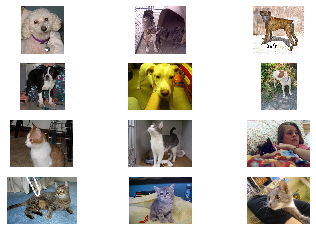

In [12]:
# 1-14
# 將取得圖像內容繪製至容器中 
for i, img_path in enumerate(next_dog_pix+next_cat_pix): 
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # 取消軸標示及格線

  img = mpimg.imread(img_path) #讀取img_path路徑下的圖片
  plt.imshow(img) #顯示圖片
    
# 顯示結果
plt.show()

```
for i, img_path in enumerate(照片的內容跟順序): 
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # 取消軸標示及格線

  img = mpimg.imread(img_path) #讀取img_path路徑下的圖片
  plt.imshow(img) #顯示圖片
```

## 1.4 自定義資料集及掛載
同理可知，當大家想訓練自己的資料集進行二分類時，首先要準備二組已標註過的圖片(比方說貓和狗)，檔名統一為類別名稱.數字.jpg(數字從0開始)。建議圖片數量不宜太少，否則訓練時容易產生過擬合問題，造成面對真實數據時正確率會驟降。

接著，這兩組圖片的每一組還要再分成兩部份，一部份作為訓練用，另一部份作為驗證用，分別放入\train及\validation路徑下。通常訓練及驗證的數量比例建議在2 : 1 ~ 5 : 1，比例不宜太高。

假設自定義資料集(dataset)中有A和B二個子集圖片，待訓練各1000張圖片，待驗證各500張圖片，則存放方式如下：

![dataset_architeture](https://raw.githubusercontent.com/OmniXRI/Colab_Dogs_and_Cats/master/dataset_architeture.jpg)

## 1.5 程式碼補充

In [13]:
# enumerate函數用於將一個可遍歷的數據對象(如列表、元組或字符串)組合為一個索引序列，同時列出數據和數據下標，一般用在 for 循環當中

In [14]:
# 1-15
seasons = ['Spring', 'Summer', 'Fall', 'Winter']
print(list(enumerate(seasons)))

[(0, 'Spring'), (1, 'Summer'), (2, 'Fall'), (3, 'Winter')]


In [15]:
# subplot圖表的整個繪圖區域被分成 numRows 行和 numCols 列然後按照從左到右，從上到下的順序對每個子區域進行編號，左上的子區域的編號為1

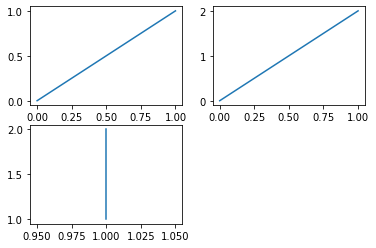

In [16]:
# 1-16
plt.subplot(2,2,1)
plt.plot([0,1],[0,1])

plt.subplot(2,2,2)
plt.plot([0,1],[0,2])

plt.subplot(2,2,3)
plt.plot([1,1],[1,2])
plt.show()